In [ ]:
adam batch size 32

In [25]:
# Essential and common packages
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, 
                                     BatchNormalization, Flatten, Conv2D, AveragePooling2D, 
                                     MaxPooling2D, GlobalMaxPooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

# For visualization of plots inside Jupyter Notebook
%matplotlib inline

In [27]:
# Parameters
dataset_url = r"C:\Users\Welcome\2750"
batch_size = 64
img_height = 64
img_width = 64
validation_split = 0.2
rescale = 1.0 / 255

# Data Augmentation with ImageDataGenerator
datagen = ImageDataGenerator(
    validation_split=validation_split,
    rescale=rescale,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_url,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Create training and validation datasets
train_dataset = datagen.flow_from_directory(
    directory=dataset_url,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training",
    class_mode='categorical',
    shuffle=True
)

test_dataset = datagen.flow_from_directory(
    directory=dataset_url,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation",
    class_mode='categorical',
    shuffle=True
)

Found 27000 files belonging to 10 classes.
Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


Images shape: (64, 64, 64, 3)
Labels shape: (64, 10)
Image 0 min value: 20, max value: 90
Image 1 min value: 34, max value: 255
Image 2 min value: 91, max value: 249
Image 3 min value: 90, max value: 246
Image 4 min value: 27, max value: 195
Image 5 min value: 106, max value: 237
Image 6 min value: 24, max value: 95
Image 7 min value: 47, max value: 243
Image 8 min value: 30, max value: 85


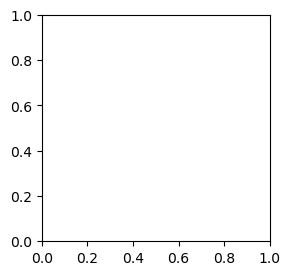

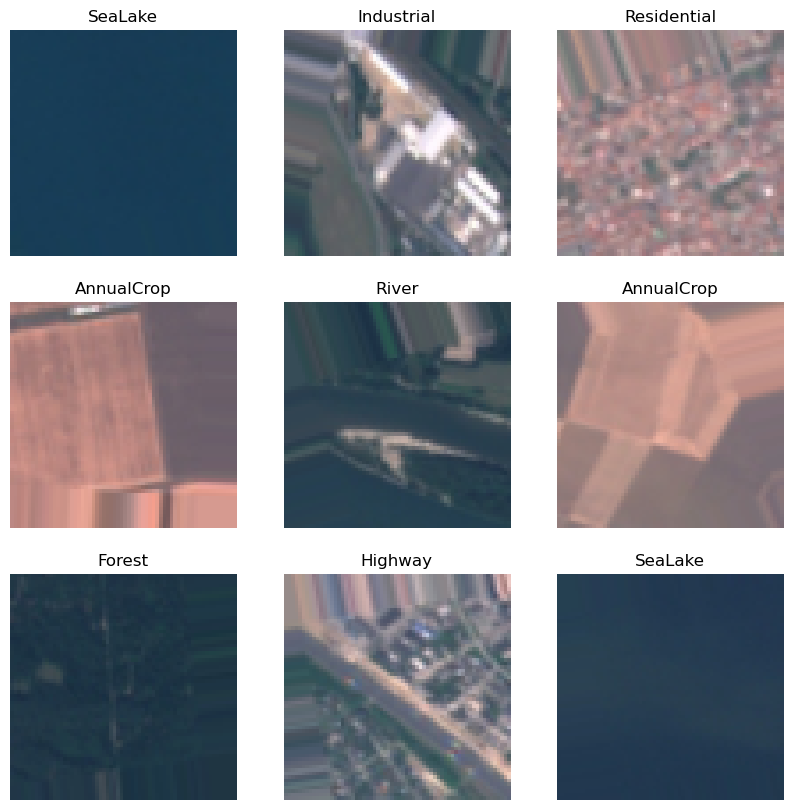

In [31]:
def visualize_images(dataset, class_indices, num_images=9):
    """
    Visualize a batch of images from the dataset.

    Parameters:
    - dataset: The dataset to visualize images from.
    - class_indices: Dictionary mapping class names to their corresponding indices.
    - num_images: Number of images to display (default: 9).
    """
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)  # Get the next batch of images and labels
    
    # Debugging: Print the shape of the images and labels
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        
        # Scale back to [0, 255] and convert to uint8
        img = images[i] * 255  # Scale back to [0, 255]
        img = img.astype("uint8")  # Convert to uint8
        
        # Debugging: Print min and max pixel values
        print(f"Image {i} min value: {img.min()}, max value: {img.max()}")
        
        plt.imshow(img)  # Display the image
        plt.title(list(class_indices.keys())[np.argmax(labels[i])])  # Get the class name from the label
        plt.axis("off")
    
    plt.show()

# Visualize training images
visualize_images(train_dataset, train_dataset.class_indices)

In [33]:
def identity_block(X, f, filters, training=True):
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    return X

def convolutional_block(X, f, filters, s=2, training=True):
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid')(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def ResNet50(input_shape=(64, 64, 3), classes=10):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    X = AveragePooling2D(pool_size=(2, 2))(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)
    model = Model(inputs=X_input, outputs=X)
    return model

In [ ]:
# Create model
model = ResNet50(input_shape=(64, 64, 3), classes=10)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, batch_size=64)

C:\Users\Welcome\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1257s 4s/step - accuracy: 0.5218 - loss: 1.6174 - val_accuracy: 0.1639 - val_loss: 3853.9888
Epoch 2/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1224s 4s/step - accuracy: 0.6581 - loss: 1.0019 - val_accuracy: 0.2628 - val_loss: 156.2495
Epoch 3/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1219s 4s/step - accuracy: 0.6920 - loss: 0.9509 - val_accuracy: 0.6117 - val_loss: 1.2664
Epoch 4/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1228s 4s/step - accuracy: 0.7483 - loss: 0.7445 - val_accuracy: 0.5713 - val_loss: 1.7334
Epoch 5/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1205s 3s/step - accuracy: 0.7698 - loss: 0.6657 - val_accuracy: 0.4648 - val_loss: 2.3184
Epoch 6/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1214s 3s/step - accuracy: 0.7914 - loss: 0.6083 - val_accuracy: 0.4706 - val_loss: 2.2035
Epoch 7/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1224s 4s/step - accuracy: 0.8055 - loss: 0.6110 - val_accuracy: 0.4589 - val_loss: 2.2258
Epoch 8/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1309s 4s/step - accuracy: 0.7399 - lo

In [11]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


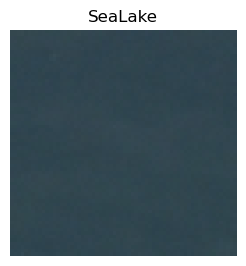

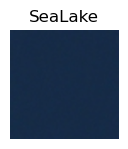

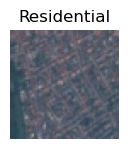

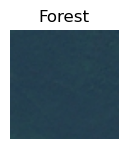

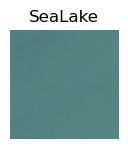

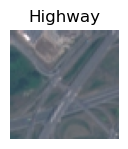

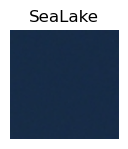

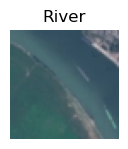

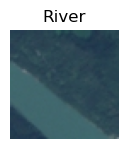

In [13]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.initializers import RandomUniform

def identity_block(X, f, filters, training=True, initializer=RandomUniform):
    """
    Implementation of the identity block.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- list of 3 integers, defining the number of filters in the CONV layers of the main path
    training -- Boolean, True for training mode, False for inference mode
    initializer -- Keras initializer, defaults to RandomUniform
    
    Returns:
    X -- Output of the identity block
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Batch norm
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # Final step: Add shortcut value to main path, and pass it through ReLU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.initializers import GlorotUniform  # Correct Import

def convolutional_block(X, f, filters, s=2, training=True, initializer=GlorotUniform):
    """
    Implementation of the convolutional block.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- Integer, specifying the shape of the middle CONV's window
    filters -- List of 3 integers, defining the number of filters in the CONV layers
    s -- Integer, specifying the stride to be used
    training -- Boolean, True for training mode, False for inference mode
    initializer -- Keras initializer, defaults to GlorotUniform (Xavier uniform)
    
    Returns:
    X -- Output of the convolutional block
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer())(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [19]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Add, AveragePooling2D
from tensorflow.keras.initializers import GlorotUniform  # Correct Import

def ResNet50(input_shape=(64, 64, 3), classes=10):
    """
    Implementation of ResNet50 model.
    
    Arguments:
    input_shape -- Shape of the input images (height, width, channels)
    classes -- Number of classes
    
    Returns:
    model -- A Keras Model instance
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=GlorotUniform())(X)  # Fixed initializer
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # You need to add identity and convolutional blocks here
    # (Skipping for now since you already defined them)

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2), padding="same")(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", kernel_initializer=GlorotUniform())(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name="ResNet50")

    return model

# Create model
model = ResNet50(input_shape=(64, 64, 3), classes=10)

# Print model summary
model.summary()


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 8, 8, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,698 (198.04 KB)

 Trainable params: 50,570 (197.54 KB)

 Non-trainable params: 128 (512.00 B)

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# please increase the epoch for higher accuracy (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, batch_size=32)

C:\Users\Welcome\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 131s 169ms/step - accuracy: 0.5151 - loss: 1.3960 - val_accuracy: 0.3120 - val_loss: 2.8412
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 96s 141ms/step - accuracy: 0.7056 - loss: 0.8562 - val_accuracy: 0.5433 - val_loss: 1.5571
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 146s 146ms/step - accuracy: 0.7628 - loss: 0.6973 - val_accuracy: 0.6694 - val_loss: 1.1222
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 100s 147ms/step - accuracy: 0.7846 - loss: 0.6301 - val_accuracy: 0.3596 - val_loss: 3.7302
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 103s 152ms/step - accuracy: 0.7935 - loss: 0.6124 - val_accuracy: 0.6380 - val_loss: 1.1000
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 146s 157ms/step - accuracy: 0.8252 - loss: 0.5171 - val_accuracy: 0.6304 - val_loss: 1.1675
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 102s 149ms/step - accuracy: 0.8293 - loss: 0.4924 - val_accuracy: 0.6167 - val_loss: 1.4096
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 107s 159ms/step - accuracy: 0

In [44]:
# model.save('lulc_20_epoch')
model.save('my_model.keras')

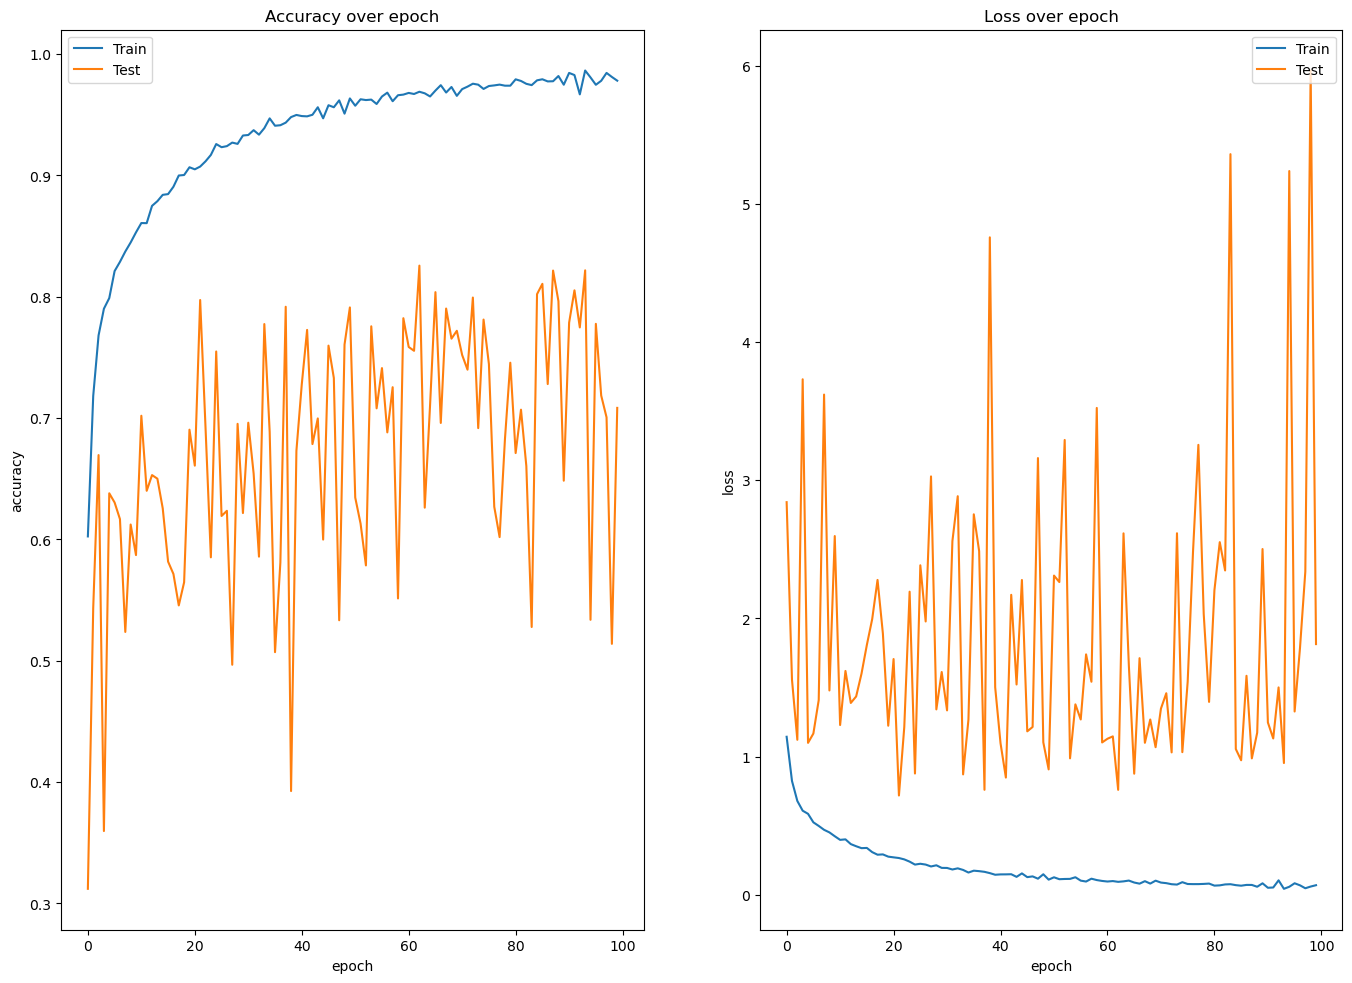

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")
plt.show()



In [38]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [81]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[752,   6,  38,   8,   1,   7, 128,   0, 113,   0],
       [  1, 978,   7,   0,   0,  15,   3,   0,  71,   0],
       [ 10,   0, 676,   9,   8,   8, 283,   4, 102,   0],
       [ 14,   0,  12, 377,  22,   1,  74,   7, 375,   0],
       [  0,   0,   7,  12, 781,   0,  17,  22,  45,   0],
       [ 50,  23,  16,   2,   0, 234,  47,   0, 325,   0],
       [  8,   0,  22,   3,   0,   0, 771,   2, 102,   0],
       [  0,   0,   0,  15,  32,   0,  25, 969,  30,   0],
       [ 14,   0,   7,   6,   4,   0,  17,   4, 839,   0],
       [101, 252,  42,   0,   0,  52,   2,   0, 182, 424]], dtype=int64)

In [83]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [85]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

Confusion matrix, without normalization
[[752   6  38   8   1   7 128   0 113   0]
 [  1 978   7   0   0  15   3   0  71   0]
 [ 10   0 676   9   8   8 283   4 102   0]
 [ 14   0  12 377  22   1  74   7 375   0]
 [  0   0   7  12 781   0  17  22  45   0]
 [ 50  23  16   2   0 234  47   0 325   0]
 [  8   0  22   3   0   0 771   2 102   0]
 [  0   0   0  15  32   0  25 969  30   0]
 [ 14   0   7   6   4   0  17   4 839   0]
 [101 252  42   0   0  52   2   0 182 424]]


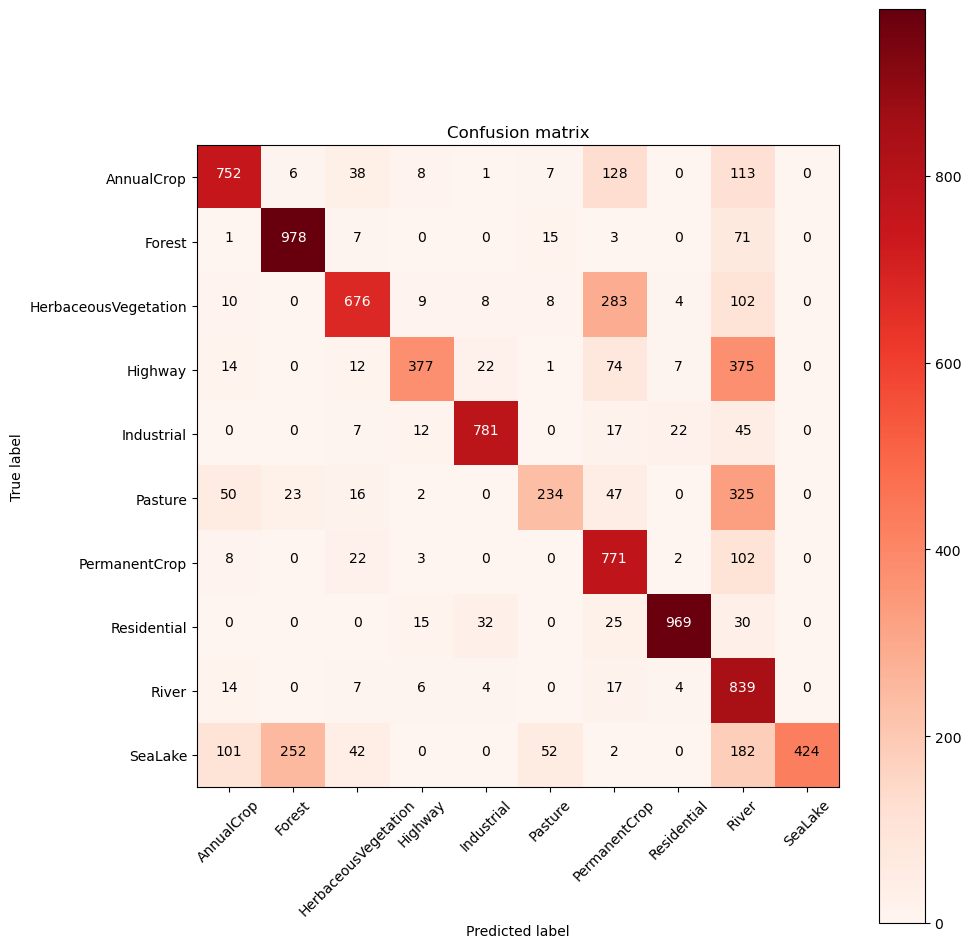

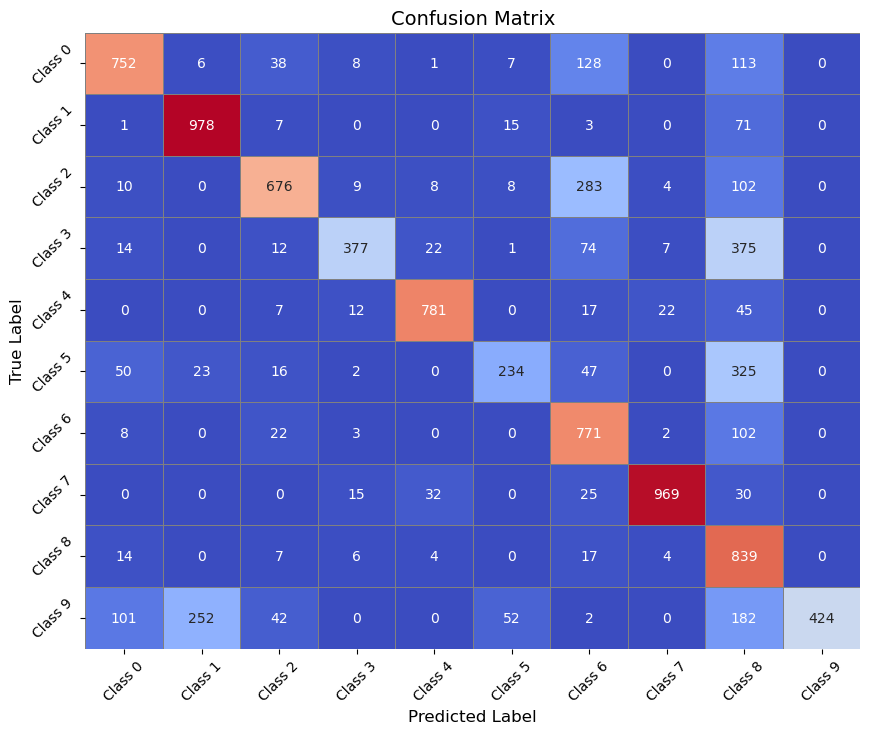

In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', figsize=(10, 8), cmap="coolwarm"):
    """
    Plots a visually enhanced confusion matrix without the color bar.
    
    Parameters:
    - cm: Confusion matrix (numpy array)
    - classes: List of class labels
    - normalize: If True, normalizes values to percentages
    - title: Title of the plot
    - figsize: Size of the figure
    - cmap: Color map for visualization
    """
    
    plt.figure(figsize=figsize)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize each row (class-wise)
        fmt = ".2f"  # Show percentages with 2 decimal places
    else:
        fmt = "d"  # Show whole numbers
    
    # Create a heatmap without the color bar
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, linewidths=0.5, linecolor='gray',
                xticklabels=classes, yticklabels=classes, cbar=False)

    # Titles and labels
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    # Show the plot
    plt.show()


# Confusion Matrix (10 classes)
cm = np.array([[752,   6,  38,   8,   1,   7, 128,   0, 113,   0],
               [  1, 978,   7,   0,   0,  15,   3,   0,  71,   0],
               [ 10,   0, 676,   9,   8,   8, 283,   4, 102,   0],
               [ 14,   0,  12, 377,  22,   1,  74,   7, 375,   0],
               [  0,   0,   7,  12, 781,   0,  17,  22,  45,   0],
               [ 50,  23,  16,   2,   0, 234,  47,   0, 325,   0],
               [  8,   0,  22,   3,   0,   0, 771,   2, 102,   0],
               [  0,   0,   0,  15,  32,   0,  25, 969,  30,   0],
               [ 14,   0,   7,   6,   4,   0,  17,   4, 839,   0],
               [101, 252,  42,   0,   0,  52,   2,   0, 182, 424]])

# Define class labels
class_labels = [f'Class {i}' for i in range(10)]

# Call function to plot confusion matrix
plot_confusion_matrix(cm, class_labels, normalize=False, cmap="coolwarm")

